# Tropical cyclone hazard for displacement risk modelling

This tutorial shows how to use the TC hazard event sets for historical and future periods.

Technical specifications.

Resolution: 150 arcsec 

**Emission scenarios considered:** SSP245, SSP370, SSP585.  
**GCMs considered:** .  
**(Future) years considered:** 1980-2018 (ERA-5) & 1995-2014 (20thcal GCM output) - 2041-2060, 2081-2100.  

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import exposure, vulnerability

### Country to basin assignment - step 1

For tropical cyclone, the hazard data is split up into four broad regions. We first need to assign each country to the respective TC region. We do this in a 3 step process:

1. check if there's a match with existing region/country dictionaries  
2. if not, keep the regions in the 'ROW' category and first get exposure data from the country; then, from the countries lat/lon, try to assign the country to a basin  
3. if the country spans multiple basins, keep the 'ROW' category and load the global TC data

Step 1 follows next. Step 2 and 3 further below.

In [2]:
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
iso3n_per_region = ImpfSetTropCyclone.get_countries_per_region()[3]

In [3]:
region_ids_TC_bsn = dict(iso3n_per_region)  # Copy original dictionary

# Combine NA1 and NA2
region_ids_TC_bsn['AP'] = region_ids_TC_bsn.pop('NA1') + region_ids_TC_bsn.pop('NA2')

# Get the value associated with key 'NI'
ni_values = region_ids_TC_bsn.pop('NI')

# Add the key 'IO' with the retrieved value
region_ids_TC_bsn['IO'] = ni_values

# Combine OC and SI
region_ids_TC_bsn['SH'] = region_ids_TC_bsn.pop('OC') + region_ids_TC_bsn.pop('SI')

# Combine WP1, WP2, WP3, and WP4
region_ids_TC_bsn['WP'] = region_ids_TC_bsn.pop('WP1') + region_ids_TC_bsn.pop('WP2') + region_ids_TC_bsn.pop('WP3') + region_ids_TC_bsn.pop('WP4')

In [4]:
def get_region(country):
    for region, countries in region_ids_TC_bsn.items():
        if country in countries:
            return region
    return None

cntry_iso = 'TWN'
reg = get_region(cntry_iso)

reg

'WP'

## Load exposure from BEM

In [5]:
from climada.entity.exposures import Exposures

In [6]:
# Load exposure
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_iso, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>1] # filter out rows with basically no population
gdf_bem_subcomps["impf_TC"] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_TCIMPF_HAZUS[row.se_seismo], axis=1)
gdf_bem_subcomps = exposure.assign_admin1_attr(gdf_bem_subcomps, exposure.path_admin1_attrs, source='gadm')

In [7]:
# Make expousre
exp = Exposures(gdf_bem_subcomps.copy())
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,value,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_TC,admin1,longitude,latitude
0,157350270,TWN,3,edu_pub,RM2L,3.203340,0.033985,66.665,33.335,0.0,POINT (118.45417 24.47083),5,3260.0,118.454167,24.470833
1,157350270,TWN,3,edu_pub,C1M,4.835457,0.051300,66.665,33.335,0.0,POINT (118.45417 24.47083),1,3260.0,118.454167,24.470833
2,157350270,TWN,3,edu_pub,C1L,5.618275,0.059605,66.665,33.335,0.0,POINT (118.45417 24.47083),1,3260.0,118.454167,24.470833
3,157350270,TWN,3,emp_ind,RM2L,4.031061,0.213832,66.665,33.335,0.0,POINT (118.45417 24.47083),5,3260.0,118.454167,24.470833
4,157350270,TWN,3,emp_ind,C1M,6.084906,0.322780,66.665,33.335,0.0,POINT (118.45417 24.47083),1,3260.0,118.454167,24.470833


In [8]:
print('Total population '+str(cntry_iso)+': ' + "{:,.0f}".format(exp.gdf.value.sum()))

Total population TWN: 39,165,597


**Make a new exposure object for each admin1 region**

In [9]:
ad1 = np.unique(exp.gdf.admin1).tolist()

In [10]:
import copy as cp

exp_dict = {}
exp_dict['admin0'] = exp
for admin1 in ad1:
    admin1_gdf = exp.gdf[exp.gdf.admin1 == admin1]
    exp_admin1 = cp.deepcopy(exp)
    exp_admin1.gdf = admin1_gdf
    exp_dict['admin1'+'_'+str(int(admin1))] = exp_admin1

#### Get lat/lon min/max from exposure

In [11]:
lat_min, lat_max, lon_min, lon_max = exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max()

In [12]:
lat_min, lat_max, lon_min, lon_max

(21.912500005759863, 25.27916667242634, 118.28749999999884, 122.00416666666847)

In [13]:
BASIN_BOUNDS = {
    # North Atlantic/Eastern Pacific Basin
    'AP': [-180.0, 10.0, 0.0, 85.0],

    # Indian Ocean Basin
    'IO': [10.0, 100.0, 0.0, 85.0],

    # Southern Hemisphere Basin
    'SH': [-180.0, 180.0, -85.0, 0.0],

    # Western Pacific Basin
    'WP': [100.0, 180.0, 0.0, 85.0],
}

def assign_basin(lon_min, lon_max, lat_min, lat_max):
    assigned_basins = []
    
    for basin, bounds in BASIN_BOUNDS.items():
        b_lon_min, b_lon_max, b_lat_min, b_lat_max = bounds
        
        # Check if the country bounds fit entirely within a single basin
        if (lon_min >= b_lon_min and lon_max <= b_lon_max and
            lat_min >= b_lat_min and lat_max <= b_lat_max):
            return basin
        
        # Check if the country bounds overlap with the basin bounds
        if (lon_min <= b_lon_max and lon_max >= b_lon_min and
            lat_min <= b_lat_max and lat_max >= b_lat_min):
            assigned_basins.append(basin)
    
    # If the country spans multiple basins, assign 'ROW'
    if len(assigned_basins) > 1:
        return 'ROW'
    
    # If the country only fits in one basin or doesn't overlap any basin
    return assigned_basins[0] if assigned_basins else 'Unknown Basin'

In [14]:
assigned_basin = assign_basin(lon_min, lon_max, lat_min, lat_max)
print(f"The country is assigned to the {assigned_basin} basin.")

The country is assigned to the WP basin.


In [15]:
if assigned_basin != 'ROW':
    reg = assigned_basin
else:
    reg = 'ROW'

In [16]:
reg

'WP'

## Load hazard

### a) Event sets historical

In [17]:
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
hazard_dir = SYSTEM_DIR/"hazard"/"present"

In [18]:
if reg != 'ROW':
    tc_haz = TropCyclone.from_hdf5(hazard_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))
else:
    haz_list = []
    for bsn in ['AP', 'IO', 'SH', 'WP']:
        haz = TropCyclone.from_hdf5(hazard_dir.joinpath(f'TC_{bsn}_0150as_MIT_H08.hdf5'))
        haz_list.append(haz)
    tc_haz = Hazard.concat(haz_list)

In [19]:
tc_haz_sel = tc_haz.select(extent=(lon_min, lon_max, lat_min, lat_max))

<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

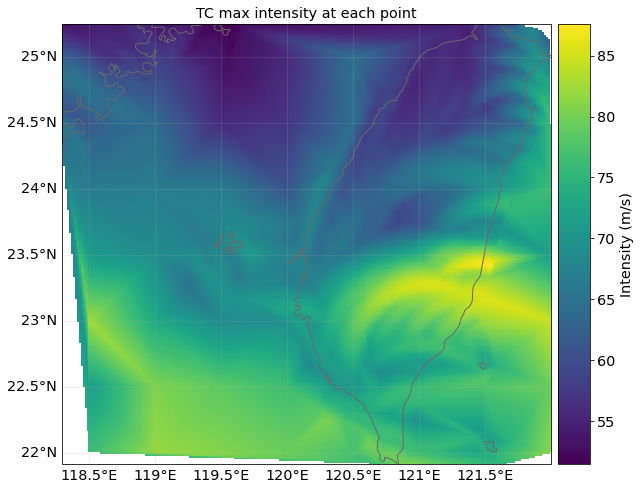

In [20]:
tc_haz_sel.plot_intensity(event=0)

### b) Event sets future

In [21]:
models = ['cesm2', 'cnrm6', 'ecearth6', 'fgoals', 'ipsl6', 'miroc6', 'mpi6', 'mri6', 'ukmo6']
rcp = 'ssp370'
scenario = ['20thcal', 'cal', '_2cal']
yr_dict = {'20thcal': 'hist',
           'cal': 2050,
          '_2cal': 2100}

In [22]:
hazard_dir = SYSTEM_DIR/"hazard"/"future"

fut_haz_dict = {}

for gcm in models:
    for scen in scenario:
        if reg != 'ROW':
            if scen == '20thcal':
                haz_str = f"TC_{reg}_0150as_MIT_{gcm}_{scen}_H08.hdf5"
                haz = TropCyclone.from_hdf5(hazard_dir.joinpath(haz_str))
                haz_sel = haz.select(extent=(lon_min, lon_max, lat_min, lat_max))
                fut_haz_dict[gcm+'_'+str(yr_dict[scen])] = haz_sel
            else:
                haz_str = f"TC_{reg}_0150as_MIT_{gcm}_{rcp}{scen}_H08.hdf5"
                haz = TropCyclone.from_hdf5(hazard_dir.joinpath(haz_str))
                haz_sel = haz.select(extent=(lon_min, lon_max, lat_min, lat_max))
                fut_haz_dict[gcm+'_'+rcp+'_'+str(yr_dict[scen])] = haz_sel
        else:
            haz_list = []
            for bsn in ['AP', 'IO', 'SH', 'WP']:
                if scen == '20thcal':
                    haz_str = f"TC_{bsn}_0150as_MIT_{gcm}_{scen}_H08.hdf5"
                else:
                    haz_str = f"TC_{bsn}_0150as_MIT_{gcm}_{rcp}{scen}_H08.hdf5"
                haz = TropCyclone.from_hdf5(hazard_dir.joinpath(haz_str))
                haz_list.append(haz)
            combined_haz = Hazard.concat(haz_list)
            haz_sel = combined_haz.select(extent=(lon_min, lon_max, lat_min, lat_max))
            if scen == '20thcal':
                fut_haz_dict[gcm+'_'+str(yr_dict[scen])] = haz_sel
            else:
                fut_haz_dict[gcm+'_'+rcp+'_'+str(yr_dict[scen])] = haz_sel

## Impact functions

In [23]:
impf_set_tc = vulnerability.IMPF_SET_TC_HAZUS

In [24]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_tc_step = ImpactFuncSet()

In [25]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thresh = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_tc.get_ids(haz_type='TC'):
    impf_set_tc.get_func(fun_id=imp_id)
    y = impf_set_tc.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_tc.get_func(fun_id=imp_id)[0].mdd
    thresh = np.interp(building_thresh, x, y)
    impf_set_tc_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  thresh, thresh *10),
                    haz_type='TC',
                    impf_id=imp_id,
                    intensity_unit = 'm/s'
                )
    )

## Impacts

### a) Historical

In [26]:
from climada.engine import ImpactCalc

impcalc = ImpactCalc(exp, impf_set_tc_step, tc_haz_sel)
impact = impcalc.impact()

In [27]:
print('Annual average displacement: ' + "{:,.0f}".format(impact.aai_agg))

Annual average displacement: 6,687


<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (Pop. count)'>

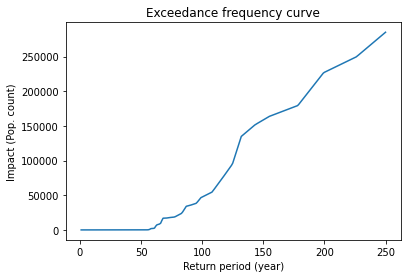

In [28]:
freq_curve = impact.calc_freq_curve(return_per=np.arange(1, 251, 1))
rp_indices = [9, 24, 49, 99, 249]
pm_data_hist = [freq_curve.impact[idx] for idx in rp_indices]
freq_curve.plot()

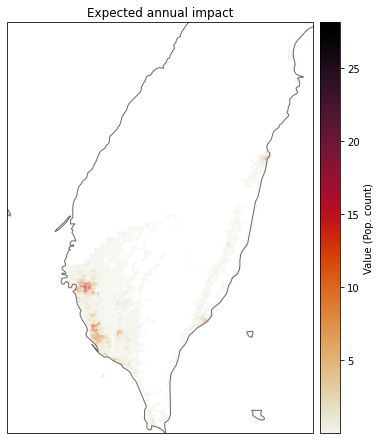

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Use the plot method and pass the GeoAxes
impact.plot_hexbin_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

### b) Future

In [30]:
impact_dict = {}
for fut, haz in fut_haz_dict.items():
    impcalc_fut = ImpactCalc(exp, impf_set_tc_step, haz)
    impact_fut = impcalc_fut.impact()
    impact_dict[fut] = impact_fut

In [31]:
aai_agg_dict = {}
pmd_dict = {}
for fut, imp in impact_dict.items():
    aai_agg_dict[fut] = imp.aai_agg
    freq_curve = imp.calc_freq_curve(return_per=np.arange(1, 251, 1))
    pm_data = [freq_curve.impact[idx] for idx in rp_indices]
    pmd_dict[fut] = pm_data

In [32]:
aai_agg_dict = {'ERA-5_hist': impact.aai_agg, **aai_agg_dict}

In [33]:
pmd_dict = {'ERA-5_hist': pm_data_hist, **pmd_dict}

In [34]:
# Create DataFrame
data = {
    'Model': [],
    'Scenario': [],
    'Period': [],
    'AAD': []
}

for key, value in aai_agg_dict.items():
    parts = key.split('_')
    if len(parts) == 3: 
        model, scenario, period = parts
    elif len(parts) == 2: 
        model, scenario = parts
        period = ""
    else:
        continue

    data['Model'].append(model)
    data['Scenario'].append(scenario)
    data['Period'].append(period)
    data['AAD'].append(value)

df = pd.DataFrame(data)

# Iterate and add new columns for each RP value
for rp, rp_value in zip([10, 25, 50, 100, 250], zip(*pmd_dict.values())):
    df[f'RP_{rp}'] = rp_value

df

,Model,Scenario,Period,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,ERA-5,hist,,6687.096842,0.000000,0.000000e+00,0.000000e+00,4.744743e+04,2.851251e+05
1,cesm2,hist,,72864.146714,0.000000,1.603371e+03,1.197486e+05,4.276510e+06,7.327230e+06
2,cesm2,ssp370,2050,311347.272932,21065.981666,3.134197e+06,5.683218e+06,9.581845e+06,1.364456e+07
3,cesm2,ssp370,2100,527645.085988,382050.997486,4.606480e+06,1.015065e+07,1.350674e+07,2.039270e+07
4,cnrm6,hist,,37577.694612,0.000000,0.000000e+00,1.370557e+04,8.687396e+04,6.582100e+06
5,cnrm6,ssp370,2050,191082.272300,23799.565715,1.344210e+06,3.573364e+06,5.821732e+06,8.346938e+06
6,cnrm6,ssp370,2100,193304.251348,75950.313188,1.110361e+06,4.492519e+06,5.411839e+06,9.775241e+06
7,ecearth6,hist,,31.776409,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,ecearth6,ssp370,2050,40418.223645,0.000000,0.000000e+00,3.012652e+04,7.372270e+05,6.688891e+06
9,ecearth6,ssp370,2100,26532.387627,0.000000,7.966872e+02,2.787883e+04,5.995986e+05,2.465057e+06


In [35]:
# Filter out the rows to exclude 'ERA-5', 'hist', and empty 'Period'
filtered_df = df[(df['Model'] != 'ERA-5')]

# Calculate the median for AAD, RP_10 ... RP_250 for each combination of scenario and period and store the median values in a new dataframe called "df_abs"
df_abs = filtered_df.groupby(['Scenario', 'Period']).median().reset_index()
df_abs

,Scenario,Period,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,hist,,6170.700857,0.0,0.000000,0.000000,2546.398546,2.121792e+05
1,ssp370,2050,40418.223645,0.0,1477.730378,70954.745202,810762.504413,6.688891e+06
2,ssp370,2100,29422.584498,0.0,2356.785701,75464.613795,548542.432273,4.907722e+06


In [36]:
# take multi-model median of the delta values...

In [37]:
# Calculate the delta_df
delta_df_list = []

# Filter out the hist scenarios
hist_df = df[(df['Model'] != 'ERA-5') & (df['Scenario'] == 'hist')]

# Loop through each Model
for model in df['Model'].unique():
    # Filter the DataFrame for the current model
    model_df = df[df['Model'] == model]
    
    # Check if hist values exist for the current model
    if not model_df[model_df['Scenario'] == 'hist'].empty:
        # Get the hist values for the current model
        hist_values = model_df[model_df['Scenario'] == 'hist'].iloc[0]

        # Loop through each period
        for period in ['2050', '2100']:
            scenario_df = model_df[model_df['Period'] == period]
            if not scenario_df.empty:
                # Calculate the difference
                delta_values = scenario_df.iloc[0].copy()
                # Ensure only numeric columns are processed
                for col in df.columns[3:]:  # Adjust index as needed
                    if pd.api.types.is_numeric_dtype(df[col]):
                        delta_values[col] = scenario_df.iloc[0][col] - hist_values[col]
                #delta_values['Scenario'] = f'ssp245_{period}_delta'
                delta_df_list.append(delta_values)

# Combine all delta values into a single DataFrame
delta_df = pd.DataFrame(delta_df_list)

delta_df

,Model,Scenario,Period,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
2,cesm2,ssp370,2050,238483.126219,21065.981666,3.132593e+06,5.563470e+06,5.305335e+06,6.317327e+06
3,cesm2,ssp370,2100,454780.939274,382050.997486,4.604877e+06,1.003090e+07,9.230234e+06,1.306547e+07
5,cnrm6,ssp370,2050,153504.577688,23799.565715,1.344210e+06,3.559659e+06,5.734858e+06,1.764838e+06
6,cnrm6,ssp370,2100,155726.556735,75950.313188,1.110361e+06,4.478814e+06,5.324965e+06,3.193141e+06
8,ecearth6,ssp370,2050,40386.447237,0.000000,0.000000e+00,3.012652e+04,7.372270e+05,6.688891e+06
9,ecearth6,ssp370,2100,26500.611218,0.000000,7.966872e+02,2.787883e+04,5.995986e+05,2.465057e+06
11,fgoals,ssp370,2050,91010.440087,174678.670109,1.550217e+06,1.042179e+06,-4.030431e+04,2.419603e+05
12,fgoals,ssp370,2100,165471.295846,13772.563953,2.021312e+06,3.953938e+06,2.721482e+06,3.905483e+06
14,ipsl6,ssp370,2050,62889.450971,0.000000,1.109089e+04,2.263806e+05,1.209358e+06,7.139564e+06
15,ipsl6,ssp370,2100,12552.650582,0.000000,1.994767e+04,1.285667e+05,5.485424e+05,1.085860e+06


In [38]:
hist_df = df_abs.iloc[0]
diff_df = delta_df.groupby('Period').median().reset_index()
for column in ['AAD', 'RP_10', 'RP_25', 'RP_50', 'RP_100', 'RP_250']:
    diff_df[column] = diff_df[column] - hist_df[column]
diff_df

,Period,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,2050,34215.746380,0.0,1477.730378,70954.745202,734680.600877,2.956795e+06
1,2100,20329.910361,0.0,2356.785701,75464.613795,545996.033727,2.980962e+06


In [39]:
era5_df = df[df['Model'] == 'ERA-5'].drop(columns=['Model', 'Scenario', 'Period'])
era5_df

,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,6687.096842,0.0,0.0,0.0,47447.426898,285125.133447


In [40]:
df_fut = diff_df.copy()
for column in ['AAD', 'RP_10', 'RP_25', 'RP_50', 'RP_100', 'RP_250']:
    df_fut[column] = df_fut[column] + era5_df[column].values[0]
    
df_fut

,Period,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,2050,40902.843222,0.0,1477.730378,70954.745202,782128.027775,3.241920e+06
1,2100,27017.007203,0.0,2356.785701,75464.613795,593443.460625,3.266087e+06


In [48]:
df_fut['Scenario'] = rcp
era5_df['Scenario'] = rcp
era5_df['Period'] = 'hist'

res_df = pd.concat([era5_df, df_fut], ignore_index=True)

columns_order = ['Period', 'Scenario', 'AAD', 'RP_10', 'RP_25', 'RP_50', 'RP_100', 'RP_250']
res_df = res_df[columns_order]

In [49]:
#res_df = pd.concat([era5_df, df_fut], ignore_index=True)
res_df

,Period,Scenario,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,hist,ssp370,1835.049690,0.0,0.000000,0.000000,35334.879021,1.603351e+05
1,2050,ssp370,11753.878734,0.0,456.090972,30126.517889,316334.789606,1.134463e+06
2,2100,ssp370,10715.677413,0.0,166.916045,55829.597474,376814.985293,1.237485e+06


## Including admin1 regions

In [43]:
# Initialize a list to store DataFrames
all_dfs = []

for key, exp_obj in exp_dict.items():
    # Perform calculations as before but within the loop
    
    impcalc = ImpactCalc(exp_obj, impf_set_tc_step, tc_haz_sel)
    impact = impcalc.impact()

    freq_curve = impact.calc_freq_curve(return_per=np.arange(1, 251, 1))
    rp_indices = [9, 24, 49, 99, 249]
    pm_data_hist = [freq_curve.impact[idx] for idx in rp_indices]

    impact_dict = {}
    for fut, haz in fut_haz_dict.items():
        impcalc_fut = ImpactCalc(exp_obj, impf_set_tc_step, haz)
        impact_fut = impcalc_fut.impact()
        impact_dict[fut] = impact_fut

    aai_agg_dict = {}
    pmd_dict = {}
    for fut, imp in impact_dict.items():
        aai_agg_dict[fut] = imp.aai_agg
        freq_curve = imp.calc_freq_curve(return_per=np.arange(1, 251, 1))
        pm_data = [freq_curve.impact[idx] for idx in rp_indices]
        pmd_dict[fut] = pm_data

    aai_agg_dict = {'ERA-5_hist': impact.aai_agg, **aai_agg_dict}
    pmd_dict = {'ERA-5_hist': pm_data_hist, **pmd_dict}

    # Create DataFrame
    data = {
        'Model': [],
        'Scenario': [],
        'Period': [],
        'AAD': []
    }

    for fut_key, value in aai_agg_dict.items():
        parts = fut_key.split('_')
        if len(parts) == 3: 
            model, scenario, period = parts
        elif len(parts) == 2: 
            model, scenario = parts
            period = ""
        else:
            continue

        data['Model'].append(model)
        data['Scenario'].append(scenario)
        data['Period'].append(period)
        data['AAD'].append(value)

    df = pd.DataFrame(data)

    # Iterate and add new columns for each RP value
    for rp, rp_value in zip([10, 25, 50, 100, 250], zip(*pmd_dict.values())):
        df[f'RP_{rp}'] = rp_value

    # Filter out the rows to exclude 'ERA-5'
    filtered_df = df[(df['Model'] != 'ERA-5')]

    # Calculate the median for AAD, RP_10 ... RP_250 for each combination of scenario and period and store the median values in a new dataframe called "df_abs"
    df_abs = filtered_df.groupby(['Scenario', 'Period']).median().reset_index()

    # Calculate the delta_df
    delta_df_list = []

    # Loop through each Model
    for model in df['Model'].unique():
        # Filter the DataFrame for the current model
        model_df = df[df['Model'] == model]

        # Check if hist values exist for the current model
        if not model_df[model_df['Scenario'] == 'hist'].empty:
            # Get the hist values for the current model
            hist_values = model_df[model_df['Scenario'] == 'hist'].iloc[0]

            # Loop through each period
            for period in ['2050', '2100']:
                scenario_df = model_df[model_df['Period'] == period]
                if not scenario_df.empty:
                    # Calculate the difference
                    delta_values = scenario_df.iloc[0].copy()
                    # Ensure only numeric columns are processed
                    for col in df.columns[3:]:  # Adjust index as needed
                        if pd.api.types.is_numeric_dtype(df[col]):
                            delta_values[col] = scenario_df.iloc[0][col] - hist_values[col]
                    #delta_values['Scenario'] = f'{rcp}_{period}_delta'
                    delta_df_list.append(delta_values)

    # Combine all delta values into a single DataFrame
    delta_df = pd.DataFrame(delta_df_list)

    # Calculate the median of the differences for each Period
    diff_df = delta_df.groupby('Period').median().reset_index()

    # Add the differences to the ERA-5 values
    era5_df = df[df['Model'] == 'ERA-5'].drop(columns=['Model', 'Scenario', 'Period'])
    df_fut = diff_df.copy()
    for column in ['AAD', 'RP_10', 'RP_25', 'RP_50', 'RP_100', 'RP_250']:
        df_fut[column] = df_fut[column] + era5_df[column].values[0]

    # Add an identifier column to keep track of the exposure object
    df_fut['Exposure'] = key
    df_fut['Scenario'] = rcp
    era5_df['Scenario'] = rcp
    era5_df['Exposure'] = key
    era5_df['Period'] = 'hist'
    
    res_df = pd.concat([era5_df, df_fut], ignore_index=True)
    
    columns_order = ['Exposure', 'Period', 'Scenario', 'AAD', 'RP_10', 'RP_25', 'RP_50', 'RP_100', 'RP_250']
    res_df = res_df[columns_order]
    
    # Append the resulting DataFrame to the list
    all_dfs.append(res_df)

# Concatenate all DataFrames into a single DataFrame
final_combined_df = pd.concat(all_dfs, ignore_index=True)

In [44]:
final_combined_df

,Exposure,Period,Scenario,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
0,admin0,hist,ssp370,6687.096842,0.0,0.000000,0.000000,47447.426898,2.851251e+05
1,admin0,2050,ssp370,47073.544079,0.0,1477.730378,70954.745202,784674.426321,3.454099e+06
2,admin0,2100,ssp370,33187.708060,0.0,2356.785701,75464.613795,595989.859171,3.478266e+06
3,admin1_3260,hist,ssp370,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
4,admin1_3260,2050,ssp370,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
5,admin1_3260,2100,ssp370,17.407242,0.0,0.000000,0.000000,0.000000,4.074601e+03
6,admin1_3261,hist,ssp370,2435.145525,0.0,0.000000,0.000000,0.000000,5.085596e+04
7,admin1_3261,2050,ssp370,13854.612129,0.0,0.000000,0.000000,40706.683866,4.144325e+05
8,admin1_3261,2100,ssp370,5237.253954,0.0,0.000000,0.000000,0.000000,2.264991e+05
9,admin1_3262,hist,ssp370,0.351178,0.0,0.000000,0.000000,0.000000,0.000000e+00


In [45]:
final_combined_df[final_combined_df.Exposure != 'admin0'].groupby("Period").sum()

,AAD,RP_10,RP_25,RP_50,RP_100,RP_250
Period,,,,,,
2050,29861.490090,0.0,456.090972,30126.517889,357041.473472,1.564957e+06
2100,32131.783457,0.0,166.916045,55829.597474,376814.985293,1.668000e+06
hist,6687.096842,0.0,0.000000,0.000000,35334.879021,2.111911e+05
